In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import timeit
from datetime import datetime
from pandas.io.json import json_normalize
import ast
import xlrd

generic = lambda x: ast.literal_eval(x)
conv = {'Purchase': generic}

#Defining a wrapper function for timings.
def wrapper(func, *args, **kwargs):
    def wrapped():
        return func(*args, **kwargs)
    return wrapped

#Building a timing function to evaluate function efficiency
def time_function(size, function):
    ls_times = []
    for n in range(size):
        ls_random = np.random.choice(100,n,replace=True).tolist()
        #print len(ls_random), mystery(ls_random)
        wrapped = wrapper(function, ls_random)
        exec_time = timeit.timeit(wrapped, number=10)
        ls_times.append(exec_time)
        
    return ls_times

## Part 1

### ETL Pipeline and SQL
You are a member of the Bebop, an eclectic interplanetary bar/ship dealing mostly in rare weapons. Your boss has recently tasked you with organizing the ship’s transactional data, as he is looking to make operations more efficient and increase booty for the ship. 

#### Section A:
The transaction log includes invoice number, customer id, purchases, date, and planet of each transaction from 2010-2011. The log itself is in chronological order, but its fields are messy (e.g. dates can be strings or integers). Your boss anticipates you will turn the raw data into something that he will be able to examine and use easily. Please use Python to read the raw data file (located here: https://www.dropbox.com/s/11t5bbgggrekt85/data.csv.zip?dl=0) and clean and transform its fields.

In [2]:
#Read the Data Files
df_data = pd.read_csv('./input/data.csv', converters=conv)
print 'Shape of the Data:', df_data.shape
df_data.head()

Shape of the Data: (24363, 5)


,InvoiceNo,Customer_ID,Date,Planet,Purchase
0,536365,17850.0,Dec 01 2010,Abydos,"[{u'ItemNo': u'85123A', u'UnitPrice': 2.55, u'..."
1,536366,17850.0,40513,Abydos,"[{u'ItemNo': 22633, u'UnitPrice': 1.85, u'Desc..."
2,536367,13047.0,12/01/2010,Abydos,"[{u'ItemNo': 84879, u'UnitPrice': 1.69, u'Desc..."
3,536368,13047.0,Dec 01 2010,Abydos,"[{u'ItemNo': 22960, u'UnitPrice': 4.25, u'Desc..."
4,536369,13047.0,12/01/2010,Abydos,"[{u'ItemNo': 21756, u'UnitPrice': 5.95, u'Desc..."


In [3]:
%time
#Clean the Date Field with Excel Number formats
def clean_dates(date):
    if date.isdigit():
        return datetime.fromordinal(datetime(1900, 1, 1).toordinal() + int(date) - 2)
    else:
        return date
    
df_data['Date'] = df_data['Date'].apply(clean_dates)
df_data.loc[df_data[df_data['Customer_ID'].isnull()].index, 'Customer_ID'] = 'Unknown'
df_data.head()

CPU times: user 4 µs, sys: 4 µs, total: 8 µs
Wall time: 10 µs


,InvoiceNo,Customer_ID,Date,Planet,Purchase
0,536365,17850,2010-12-01,Abydos,"[{u'ItemNo': u'85123A', u'UnitPrice': 2.55, u'..."
1,536366,17850,2010-12-01,Abydos,"[{u'ItemNo': 22633, u'UnitPrice': 1.85, u'Desc..."
2,536367,13047,2010-12-01,Abydos,"[{u'ItemNo': 84879, u'UnitPrice': 1.69, u'Desc..."
3,536368,13047,2010-12-01,Abydos,"[{u'ItemNo': 22960, u'UnitPrice': 4.25, u'Desc..."
4,536369,13047,2010-12-01,Abydos,"[{u'ItemNo': 21756, u'UnitPrice': 5.95, u'Desc..."


In [4]:
%%time
#Clean the Purchase History
#Function takes a dataframe withe Invoice#, Customer# and the Purchase JSON Object
#Returns a normalized dataframe with the Invoice#, Customer# and the Purchase details of each transaction.
#To fasten try leveraging numpy later
def clean_purchase(df):
    df_collection = pd.DataFrame()
    #For each row in the d
    for row in df.iterrows():
        ix_df = row[0] 
        sr_data = row[1]
        dict_tmp = json_normalize(sr_data.iloc[2]).to_dict()
        dict_tmp['InvoiceNo'] = sr_data.iloc[0]
        dict_tmp['Customer_ID'] = sr_data.iloc[1]
        df_collection = pd.concat([df_collection, pd.DataFrame(dict_tmp)], axis=0)

    df_collection = df_collection.reset_index(drop=True)
    return df_collection

df_purchase = clean_purchase(df_data[['InvoiceNo','Customer_ID','Purchase']])
##Cleaning the Purchase Data. Setting Customers that are null as Unknown
df_purchase.loc[df_purchase[df_purchase['Customer_ID'].isnull()].index, 'Customer_ID'] = 'Unknown'
print df_purchase.shape
df_purchase.set_index(['Customer_ID','InvoiceNo','ItemNo']).head()

(540372, 6)
CPU times: user 22min 3s, sys: 2min 3s, total: 24min 7s
Wall time: 24min 12s


In [5]:
#Write Output files for Stakeholders
df_item_lookup = df_purchase[['ItemNo','Description']].drop_duplicates().copy()
df_item_lookup = df_item_lookup.drop_duplicates(subset=['ItemNo'])

writer = pd.ExcelWriter('./output/data_clean.xlsx')
df_data.to_excel(writer,'Invoices')
df_purchase.to_excel(writer,'Purchases')
df_item_lookup.to_excel(writer,'Items')
writer.save()

In [6]:
#Understanding and Creating the Data Models
df_transactions = df_data[['InvoiceNo','Date','Customer_ID','Planet']].copy()
df_transactions['Customer_ID'] = df_transactions['Customer_ID'].apply(lambda x: int(x) if x!='Unknown' else x)
df_transactions.rename(columns={'Date':'TransactionDate'}, inplace=True)

df_invoices = df_purchase[['InvoiceNo','ItemNo','Quantity','UnitPrice']].copy()

df_item_lookup = df_purchase[['ItemNo','Description']].drop_duplicates().copy()
df_item_lookup = df_item_lookup.drop_duplicates(subset=['ItemNo'])

In [7]:
df_invoices['UpdatedDate'] = pd.to_datetime(datetime.today().strftime('%Y-%m-%d %H:%M:%S'))
df_transactions['UpdatedDate'] = pd.to_datetime(datetime.today().strftime('%Y-%m-%d %H:%M:%S'))
df_item_lookup['UpdatedDate'] = pd.to_datetime(datetime.today().strftime('%Y-%m-%d %H:%M:%S'))

df_invoices.to_csv('./output/Invoices.csv', encoding='utf-8', index=False)
df_transactions.to_csv('./output/Transactions.csv', encoding='utf-8', index=False)
df_item_lookup.to_csv('./output/Items.csv', encoding='utf-8', index=False)

#### Section B:
Load the processed data into a database of your choice (e.g. MySQL, PostgreSQL, etc.). You will need to install a database server on your computer if you don’t have one already.

Feel free to design the database schema as you see fit. However, it should at minimum include multiple dimension tables. We are looking for a sensible design that delivers efficient queries to the following questions. Please give us the SQL code you write to create the database/tables.

__Table 1: Invoices__
* Table has all the Invoice Transactions with the primary keys being InvoiceNo. Below would be an example and the corresponding DDL.

In [8]:
print df_invoices.shape
df_invoices.head()

(540372, 5)


,InvoiceNo,ItemNo,Quantity,UnitPrice,UpdatedDate
0,536365,85123A,6,2.55,2018-06-21 10:03:55
1,536365,71053,6,3.39,2018-06-21 10:03:55
2,536365,84406B,8,2.75,2018-06-21 10:03:55
3,536365,84029G,6,3.39,2018-06-21 10:03:55
4,536365,84029E,6,3.39,2018-06-21 10:03:55


__Table 2: Transactions__
* Table has all the Purchase Transactions with the primary keys being a composite of InvoiceNo, Transaction Date and Customer ID. Below would be the example and the corresponding DDL

In [9]:
print df_transactions.shape
df_transactions.head()

(24363, 5)


,InvoiceNo,TransactionDate,Customer_ID,Planet,UpdatedDate
0,536365,2010-12-01,17850,Abydos,2018-06-21 10:03:55
1,536366,2010-12-01,17850,Abydos,2018-06-21 10:03:55
2,536367,2010-12-01,13047,Abydos,2018-06-21 10:03:55
3,536368,2010-12-01,13047,Abydos,2018-06-21 10:03:55
4,536369,2010-12-01,13047,Abydos,2018-06-21 10:03:55


__Table 3: Item Details__
* Table 3 has the details of the items in an invoice with the primary key being the invoice ID. It is an lookup table. Below would be the example.

In [10]:
print df_item_lookup.shape
df_item_lookup.head()

(3958, 3)


,ItemNo,Description,UpdatedDate
0,85123A,ADORIAN CROSSBOW,2018-06-21 10:03:55
1,71053,WHITE METAL LANTERN,2018-06-21 10:03:55
2,84406B,CREAM CUPID HEARTS COAT HANGER,2018-06-21 10:03:55
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,2018-06-21 10:03:55
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,2018-06-21 10:03:55


Please write SQL queries to answer the following questions. Give us both your SQL query and your answer. Specify any assumptions you make.
1.	How many unique customers does the Bebop have?
2.	Which customer is the second biggest customer by revenue, excluding cancellations?
3.	How many customers have visited the Bebop on multiple planets?
4.	Which product has had the most price changes?
5.	Which item attracts the most new customers?
6.	Which customer has the shortest average length of time between purchases?
7.	For each invoice, calculate the total revenue for each item and return the combined revenue of the top 3 items by revenue. You can ignore invoices that have fewer than 3 items.

SQL's are given below:

## Part 2

#### MongoDB
Ignoring MongoDB excercise.

## Part 3

#### Runtime Analysis in Python

In [11]:
def mystery(array):
    mylist =[]
    for i in range(len(array)):
        for j in range(len(array)):
            elem1 = array[i]
            elem2 = array[j]
            if elem1 == elem2 and i!=j:
                if elem2 not in mylist:
                    mylist.append(elem2)
    
    return mylist

In [12]:
ls = [6,1,2,3,4,3,0,3,2,3,4,5,6,7,1,6,6,'apples','apples']
print mystery(ls)

[6, 1, 2, 3, 4, 'apples']


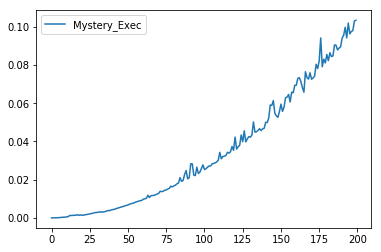

In [13]:
#Build Execution Times for Mystery
size = 200
ls_times = time_function(size, function=mystery)
df_mystery = pd.DataFrame(ls_times,range(size), columns=['Mystery_Exec'])

df_mystery.plot()

In [14]:
def efficient_mystery(array):
    ls_uniques = list(set(array))
    mylist =[]
    
    for i in range(len(ls_uniques)):
        elem = ls_uniques[i]
        elem_count = array.count(elem)
        if elem_count>1:
            mylist.append(elem)
    
    return mylist

ls = [6,1,2,3,4,3,0,3,2,3,4,5,6,7,1,6,6,'apples','apples']
print efficient_mystery(ls)

[1, 2, 3, 4, 6, 'apples']


In [15]:
#Tinkering with another version of Efficient Mystery out.
def efficient_mystery2(array):
    mylist =[]
    for x in array:
        idx = array.index(x)
        if (x in array[idx+1:]) and (x not in mylist):
            mylist.append(x)

    return mylist

ls = [6,1,2,3,4,3,0,3,2,3,4,5,6,7,1,6,6,'apples','apples']
print efficient_mystery2(ls)

[6, 1, 2, 3, 4, 'apples']


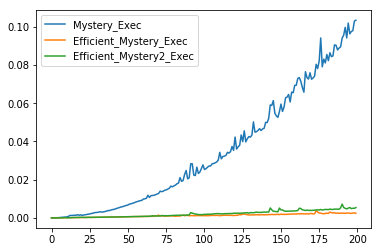

In [16]:
#Build Execution Times for Efficient Mystery
size = 200
ls_times = time_function(size, function=efficient_mystery)
df_efficient_mystery = pd.DataFrame(ls_times,range(size), columns=['Efficient_Mystery_Exec'])

#Build Execution Times for Efficient Mystery2
size = 200
ls_times = time_function(size, function=efficient_mystery2)
df_efficient_mystery2 = pd.DataFrame(ls_times,range(size), columns=['Efficient_Mystery2_Exec'])

#Compare Mystery, Efficient Mystery and Efficient Myster2 execution times
df_exec_cmp = pd.concat([df_mystery,df_efficient_mystery, df_efficient_mystery2], axis=1)
df_exec_cmp.plot()